# 4. Evaluation Metrics for Classification

In the [previous session](03_churn_prediction.ipynb) we trained a model for predicting churn.

How do we know if it´s good?

## 4.1 Evaluation metrics: session overview

- Dataset: [http://www.kaggle.com/blastchar/telco-customer-churn](http://www.kaggle.com/blastchar/telco-customer-churn)

*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.columns = df.columns.str.lower().str.replace(" ", "_")

categorical_columns = list(df.dtypes[df.dtypes == "object"].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(" ", "_")

df.totalcharges = pd.to_numeric(df.totalcharges, errors="coerce")
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == "yes").astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

In [5]:
numerical = ["tenure", "monthlycharges", "totalcharges"]

categorical = [
    "gender",
    "seniorcitizen",
    "partner",
    "dependents",
    "phoneservice",
    "multiplelines",
    "internetservice",
    "onlinesecurity",
    "onlinebackup",
    "deviceprotection",
    "techsupport",
    "streamingtv",
    "streamingmovies",
    "contract",
    "paperlessbilling",
    "paymentmethod",
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = y_pred >= 0.5
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum()

1132

In [10]:
1132 / 1409

0.8034066713981547

In [11]:
(y_val == churn_decision).mean()

0.8034066713981547

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [14]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    churn_decision = y_pred >= t
    score = (y_val == churn_decision).mean()
    print("%.2f %.3f" % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.661
0.20 0.703
0.25 0.735
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.791
0.50 0.803
0.55 0.802
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [15]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print("%.2f %.3f" % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.661
0.20 0.703
0.25 0.735
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.791
0.50 0.803
0.55 0.802
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


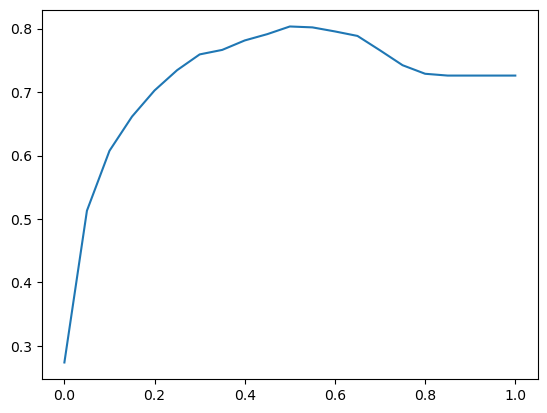

In [16]:
plt.plot(thresholds, scores);

In [17]:
from collections import Counter

In [18]:
Counter(y_pred >= 1)

Counter({False: 1409})

In [19]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [20]:
1 - y_val.mean()

0.7260468417317246

Class imbalance: the target variable is not evenly distributed.

## 4.3 Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

In [21]:
actual_positive = y_val == 1
actual_negative = y_val == 0

In [22]:
t = 0.5
predict_positive = y_pred >= t
predict_negative = y_pred < t

In [23]:
predict_negative

array([ True,  True,  True, ...,  True, False, False])

In [24]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [25]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [26]:
fp, fn

(103, 174)

In [27]:
confusion_matrix = np.array([[tn, fp], [fn, tp]])
confusion_matrix

array([[920, 103],
       [174, 212]])

In [28]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall

In [29]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

0.8034066713981547

**Precision**: Fraction of positive predictions that are correct.

In [30]:
precision = tp / (tp + fp)
precision.round(2)

0.67

**Recall**: Fraction of correctly identified positive examples.

In [31]:
recall = tp / (tp + fn)
recall.round(2)

0.55

## 4.5 ROC Curves

### TPR and FPR

true positive rate (TPR) = recall = TP / (TP + FN) => MAXIMIZE

false positive rate (FPR) = FP / (FP + TN) => MINIMIZE

In [32]:
tpr = tp / (tp + fn)
tpr.round(2)

0.55

In [33]:
fpr = fp / (fp + tn)
fpr.round(2)

0.1

In [34]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = y_val == 1
    actual_negative = y_val == 0

    predict_positive = y_pred >= t
    predict_negative = y_pred < t

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))
    # tpr = tp / (tp + fn)
    # fpr = fp / (fp + tn)

    # print("%.2f %.3f %.3f" % (t, tpr, fpr))

In [35]:
columns = ["threshold", "tp", "fp", "fn", "tn"]
df_scores = pd.DataFrame(scores, columns=columns)

df_scores["tpr"] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores["fpr"] = df_scores.fp / (df_scores.fp + df_scores.tn)

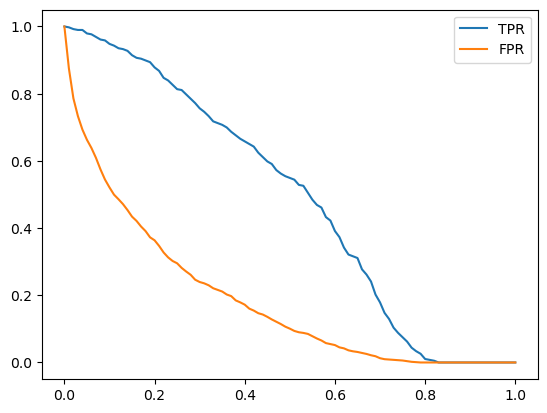

In [36]:
plt.plot(df_scores.threshold, df_scores["tpr"], label="TPR")
plt.plot(df_scores.threshold, df_scores["fpr"], label="FPR")
plt.legend()
plt.show();

### Random model

In [37]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [38]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [39]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = y_val == 1
        actual_negative = y_val == 0

        predict_positive = y_pred >= t
        predict_negative = y_pred < t

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ["threshold", "tp", "fp", "fn", "tn"]
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores["tpr"] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores["fpr"] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [40]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [41]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


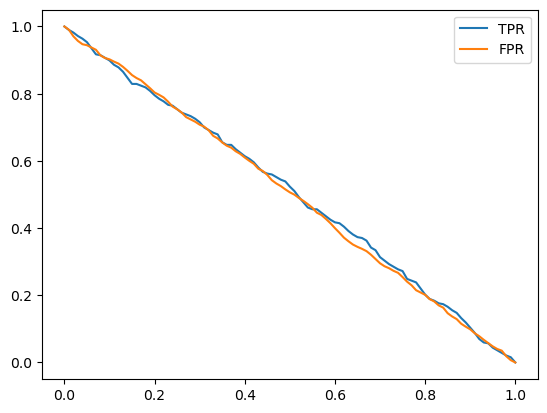

In [42]:
plt.plot(df_rand.threshold, df_rand["tpr"], label="TPR")
plt.plot(df_rand.threshold, df_rand["fpr"], label="FPR")
plt.legend()
plt.show();

### Ideal model

In [43]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [44]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
# y_ideal

In [45]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [46]:
1 - y_val.mean()

0.7260468417317246

In [47]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [48]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


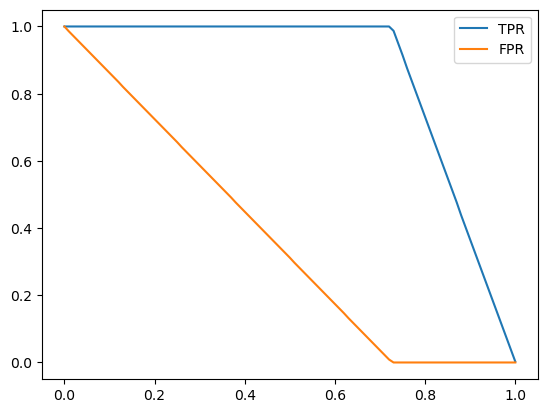

In [49]:
plt.plot(df_ideal.threshold, df_ideal["tpr"], label="TPR")
plt.plot(df_ideal.threshold, df_ideal["fpr"], label="FPR")
plt.legend()
plt.show();

### Putting everything together

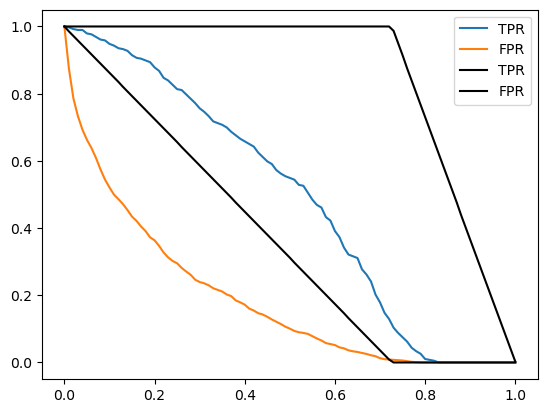

In [50]:
from pyparsing import col


plt.plot(df_scores.threshold, df_scores["tpr"], label="TPR")
plt.plot(df_scores.threshold, df_scores["fpr"], label="FPR")

# plt.plot(df_rand.threshold, df_rand["tpr"], label="TPR")
# plt.plot(df_rand.threshold, df_rand["fpr"], label="FPR")

plt.plot(df_ideal.threshold, df_ideal["tpr"], label="TPR", color="black")
plt.plot(df_ideal.threshold, df_ideal["fpr"], label="FPR", color="black")

plt.legend();

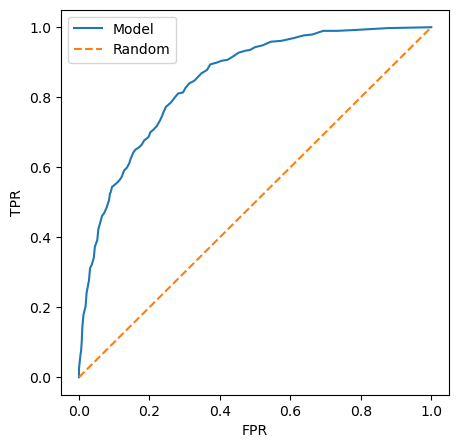

In [51]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label="Model")
plt.plot([0, 1], [0, 1], label="Random", linestyle="--")
# plt.plot(df_rand.fpr, df_rand.tpr, label="random")
# plt.plot(df_ideal.fpr, df_ideal.tpr, label="ideal")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()
plt.show();

In [52]:
from sklearn.metrics import roc_curve

In [53]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

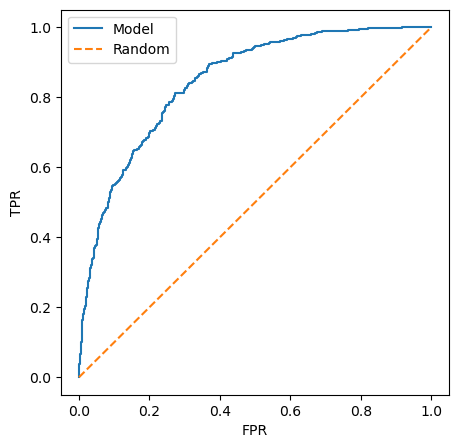

In [54]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label="Model")
plt.plot([0, 1], [0, 1], label="Random", linestyle="--")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()
plt.show();

## 4.6 ROC AUC

- Area under the ROC curve - useful metric
- Interpretation of AUC

random model: AUC = 0.5

ideal model: AUC = 1

In [55]:
from sklearn.metrics import auc

In [56]:
auc(fpr, tpr)

0.8463373497637244

In [57]:
auc(df_scores.fpr, df_scores.tpr)

0.8460182638688405

In [58]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [59]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8463373497637244

In [60]:
from sklearn.metrics import roc_auc_score

In [61]:
roc_auc_score(y_val, y_pred)

0.8463373497637244

AUC = Porbability that randomly selected positive example has higher score than randomly selected negative example.

In [62]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [63]:
import random

In [64]:
n = 100_000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.84607

In [65]:
# you can do this with numpy
n = 50_000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84912

## 4.7 Cross-Validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [66]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(max_iter=10_000, C=C)
    model.fit(X_train, y_train)

    return dv, model

In [67]:
dv, model = train(df_train, y_train, C=0.001)

In [68]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [69]:
predict(df_val, dv, model)

array([0.02499956, 0.23995521, 0.24642083, ..., 0.2468308 , 0.75555457,
       0.75891088])

In [70]:
from sklearn.model_selection import KFold

In [71]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [72]:
from tqdm.auto import tqdm

/opt/homebrew/Caskroom/miniforge/base/envs/ChurnPrediction/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print("C=%s %.3f +- %.3f" % (C, np.mean(scores), np.std(scores)))

 14%|█▍        | 1/7 [00:02<00:14,  2.46s/it]

C=0.001 0.825 +- 0.009


 29%|██▊       | 2/7 [00:10<00:29,  5.88s/it]

C=0.01 0.840 +- 0.008


 43%|████▎     | 3/7 [00:23<00:36,  9.23s/it]

C=0.1 0.842 +- 0.007


 57%|█████▋    | 4/7 [00:30<00:24,  8.30s/it]

C=0.5 0.842 +- 0.007


 71%|███████▏  | 5/7 [00:40<00:17,  8.69s/it]

C=1 0.842 +- 0.007


 86%|████████▌ | 6/7 [00:53<00:10, 10.40s/it]

C=5 0.842 +- 0.007


100%|██████████| 7/7 [01:04<00:00,  9.28s/it]

C=10 0.842 +- 0.007


In [79]:
scores

[0.8439332448917113,
 0.8447660078135346,
 0.8333774834437085,
 0.8348208575813775,
 0.8516990367418656]

In [78]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8584492508693815

use cross-validation when dataset is small

## 4.8 Summary

- Metric - a single number that describes the performance of a model
- Accuracy - fraction of correct answers; sometimes misleading
- Precision and recall are less misleading when we have class imbalance
- ROC curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
- K-Fold CV - more reliable estimate for performance (mean + std)

## 4.9 Explore more

- Check the precision and recall of the dummy classifier that always predict "FALSE"
- F1 score = 2 * P * R / (P + R)
- Evaluate precision and recall at different thresholds, plot P vs R - this way you`ll get the precision/recall curve (similar to ROC curve)
- Area under the PR curve is also a useful metric

Other projects:

- Calculate the metrics for dataset from the previous week

Continued in the next session: [05_serve_model.ipynb](05_serve_model.ipynb).